In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import (classification_report, log_loss,roc_auc_score, confusion_matrix, matthews_corrcoef)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
import optuna
import lightgbm as lgb
import catboost as cb
import joblib
import os

In [2]:
df=pd.read_csv('covtype.csv')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [4]:
def optimize_and_analyze(df):
    print(f"Original Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # 1. Downcast Binary/One-Hot Columns (Wilderness & Soil)
    # These only contain 0 or 1, so int8 (8-bit) is perfect.
    binary_cols = [col for col in df.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]
    df[binary_cols] = df[binary_cols].astype(np.int8)
    
    # 2. Downcast Continuous/Other Integer Columns
    continuous_cols = [col for col in df.columns if col not in binary_cols and col != 'Cover_Type']
    for col in continuous_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')
        
    # 3. Downcast Target Variable
    df['Cover_Type'] = pd.to_numeric(df['Cover_Type'], downcast='integer')

    print(f"Optimized Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    print("-" * 40)
    
    return df

df = optimize_and_analyze(df)

Original Memory Usage: 243.80 MB
Optimized Memory Usage: 35.46 MB
----------------------------------------


In [5]:
def check_class_distribution(df, target_col='Cover_Type'):
    print("Class Distribution (Count & Percentage):")
    
    # Calculate counts and percentages
    counts = df[target_col].value_counts()
    percentages = df[target_col].value_counts(normalize=True) * 100
    
    # Combine into a clean summary dataframe
    summary_df = pd.DataFrame({
        'Count': counts, 
        'Percentage (%)': percentages.round(2)
    })
    
    print(summary_df)
    
check_class_distribution(df)

Class Distribution (Count & Percentage):
             Count  Percentage (%)
Cover_Type                        
2           283301           48.76
1           211840           36.46
3            35754            6.15
7            20510            3.53
6            17367            2.99
5             9493            1.63
4             2747            0.47


In [6]:
def engineer_features(df):
    
    #Applies domain-specific feature engineering to the Forest Cover dataset.
    df_engineered = df.copy()
    
    # 1. True Distance to Water (Euclidean)
    df_engineered['Euclidean_Distance_To_Hydrology'] = np.sqrt(
        df_engineered['Horizontal_Distance_To_Hydrology']**2 + 
        df_engineered['Vertical_Distance_To_Hydrology']**2
    )
    
    # 2. Absolute Water Elevation
    df_engineered['Water_Elevation'] = df_engineered['Elevation'] - df_engineered['Vertical_Distance_To_Hydrology']
    
    # 3. Sunlight/Illumination Metrics
    df_engineered['Mean_Hillshade'] = df_engineered[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    df_engineered['Morning_vs_Afternoon_Sun'] = df_engineered['Hillshade_9am'] - df_engineered['Hillshade_3pm']
    
    # 4. Human/Fire Accessibility Index
    df_engineered['Distance_To_Amenities'] = df_engineered['Horizontal_Distance_To_Roadways'] + df_engineered['Horizontal_Distance_To_Fire_Points']
    
    return df_engineered

# Apply the transformations
df = engineer_features(df)
print(f"Total features now: {df.shape[1]}")

Total features now: 60


d:\Self_Projects\Tensor_flow\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\nafay\AppData\Local\Temp\ipykernel_10848\699219572.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cover_Type', y=feature, data=df, inner="quartile", palette="muted")
C:\Users\nafay\AppData\Local\Temp\ipykernel_10848\699219572.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cover_Type', y=feature, data=df, inner="quartile", palette="muted")


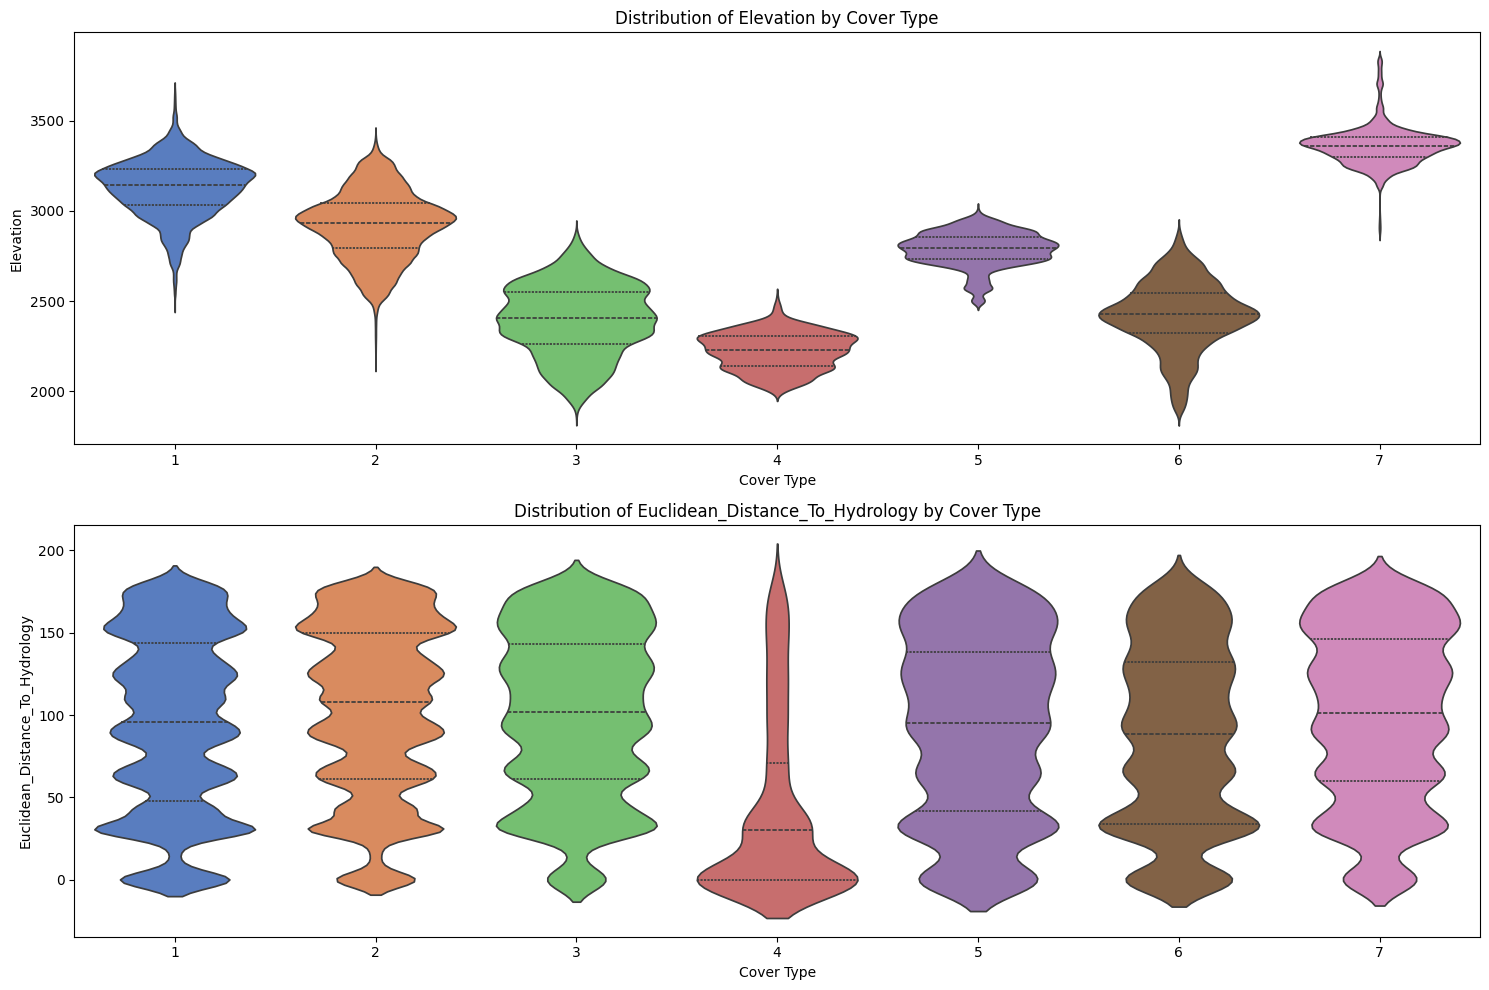

In [7]:
def plot_feature_separation(df, features):
    """
    Plots violin plots for given features against the target variable.
    """
    plt.figure(figsize=(15, 5 * len(features)))
    for i, feature in enumerate(features, 1):
        plt.subplot(len(features), 1, i)
        sns.violinplot(x='Cover_Type', y=feature, data=df, inner="quartile", palette="muted")
        plt.title(f'Distribution of {feature} by Cover Type')
        plt.ylabel(feature)
        plt.xlabel('Cover Type')
    plt.tight_layout()
    plt.show()

plot_feature_separation(df, ['Elevation', 'Euclidean_Distance_To_Hydrology'])

In [8]:
def check_skewness(df, features):
    """
    Calculates skewness for continuous features. 
    Values > 1 or < -1 indicate highly skewed distributions.
    """
    skew_vals = df[features].skew().sort_values(ascending=False)
    print("Feature Skewness:")
    print(skew_vals)
    
continuous_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                       'Euclidean_Distance_To_Hydrology']

check_skewness(df, continuous_features)

Feature Skewness:
Vertical_Distance_To_Hydrology      1.790250
Horizontal_Distance_To_Hydrology    1.140437
Slope                               0.789273
Horizontal_Distance_To_Roadways     0.713679
Aspect                              0.402628
Euclidean_Distance_To_Hydrology    -0.225039
Elevation                          -0.817596
dtype: float64


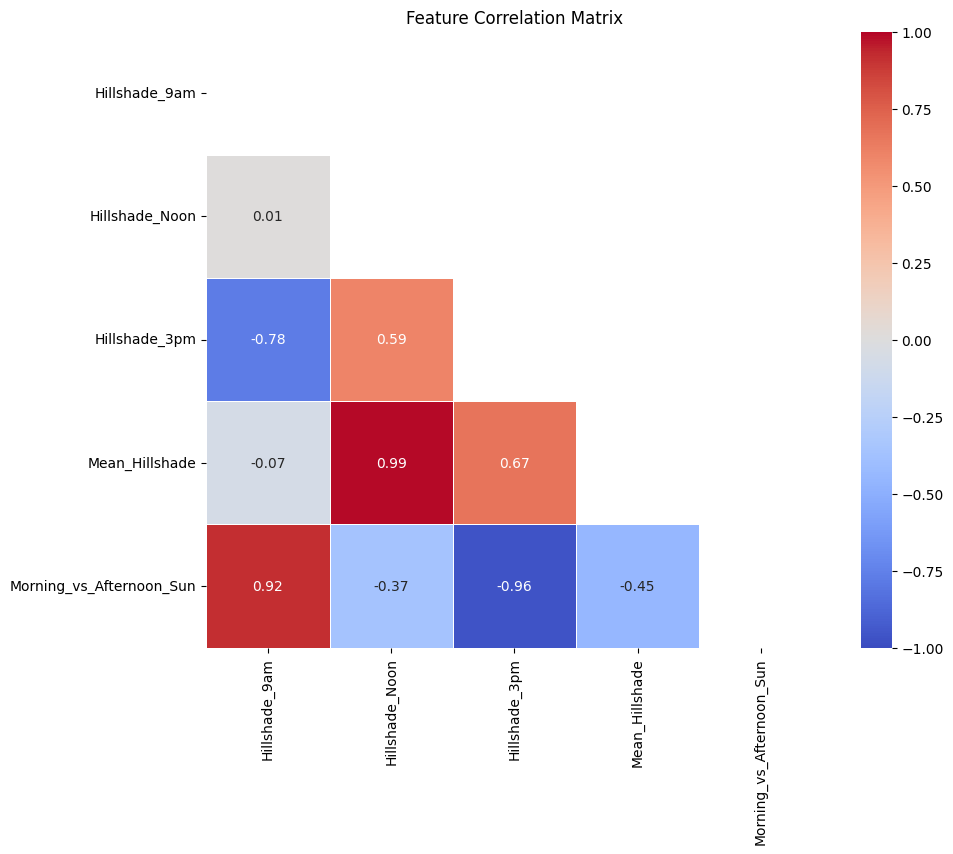

In [9]:
def plot_correlation_matrix(df, features):
    """
    Plots a heatmap of the Pearson correlation matrix.
    """
    corr = df[features].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                vmin=-1, vmax=1, square=True, linewidths=.5)
    plt.title('Feature Correlation Matrix')
    plt.show()

plot_correlation_matrix(df, ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Mean_Hillshade', 'Morning_vs_Afternoon_Sun'])

In [10]:
def test_transformations(df, feature):
    print(f"--- Analyzing: {feature} ---")
    
    # 1. Original Skewness
    orig_skew = skew(df[feature])
    print(f"Original Skewness: {orig_skew:.4f}")
    
    # 2. Log1p Transformation (log(x+1))
    log1p_data = np.log1p(df[feature])
    log_skew = skew(log1p_data)
    print(f"Log1p Skewness:    {log_skew:.4f}")
    
    # 3. Yeo-Johnson Transformation
    pt = PowerTransformer(method='yeo-johnson')
    yj_data = pt.fit_transform(df[[feature]])
    yj_skew = skew(yj_data)
    print(f"Yeo-Johnson Skew:  {yj_skew[0]:.4f}")
    
    print("-" * 35)

# Test our two worst offenders
test_transformations(df, 'Vertical_Distance_To_Hydrology')
test_transformations(df, 'Horizontal_Distance_To_Hydrology')

--- Analyzing: Vertical_Distance_To_Hydrology ---
Original Skewness: 1.7902
Log1p Skewness:    nan


d:\Self_Projects\Tensor_flow\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Self_Projects\Tensor_flow\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Yeo-Johnson Skew:  0.3315
-----------------------------------
--- Analyzing: Horizontal_Distance_To_Hydrology ---
Original Skewness: 1.1404
Log1p Skewness:    -2.1334
Yeo-Johnson Skew:  -0.1044
-----------------------------------


In [11]:
def build_preprocessor(df):
    
    # We deliberately exclude 'Cover_Type' (target) and our highly correlated 
    # engineered features ('Mean_Hillshade', 'Morning_vs_Afternoon_Sun') 
    # so they get dropped automatically.
    
    binary_features = [col for col in df.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]
    
    continuous_features = [
        'Elevation', 'Aspect', 'Slope', 
        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
        'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Euclidean_Distance_To_Hydrology', 'Water_Elevation', 'Distance_To_Amenities'
    ]
    
    # Step A: Yeo-Johnson to fix skewness and handle negative numbers
    # Step B: StandardScaler to force mean=0 and variance=1
    continuous_pipeline = Pipeline(steps=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('continuous', continuous_pipeline, continuous_features),
            ('binary', 'passthrough', binary_features) # Leave 0s and 1s alone
        ],
        remainder='drop' # This is the magic that drops the redundant columns
    )
    
    print(f"Pipeline built! Configured to process {len(continuous_features)} continuous and {len(binary_features)} binary features.")
    return preprocessor, continuous_features, binary_features

# Instantiate the pipeline
preprocessor, cont_cols, bin_cols = build_preprocessor(df)

Pipeline built! Configured to process 13 continuous and 44 binary features.


Initializing Pipeline...
Applying mathematical transformations...
Generating visual plots...


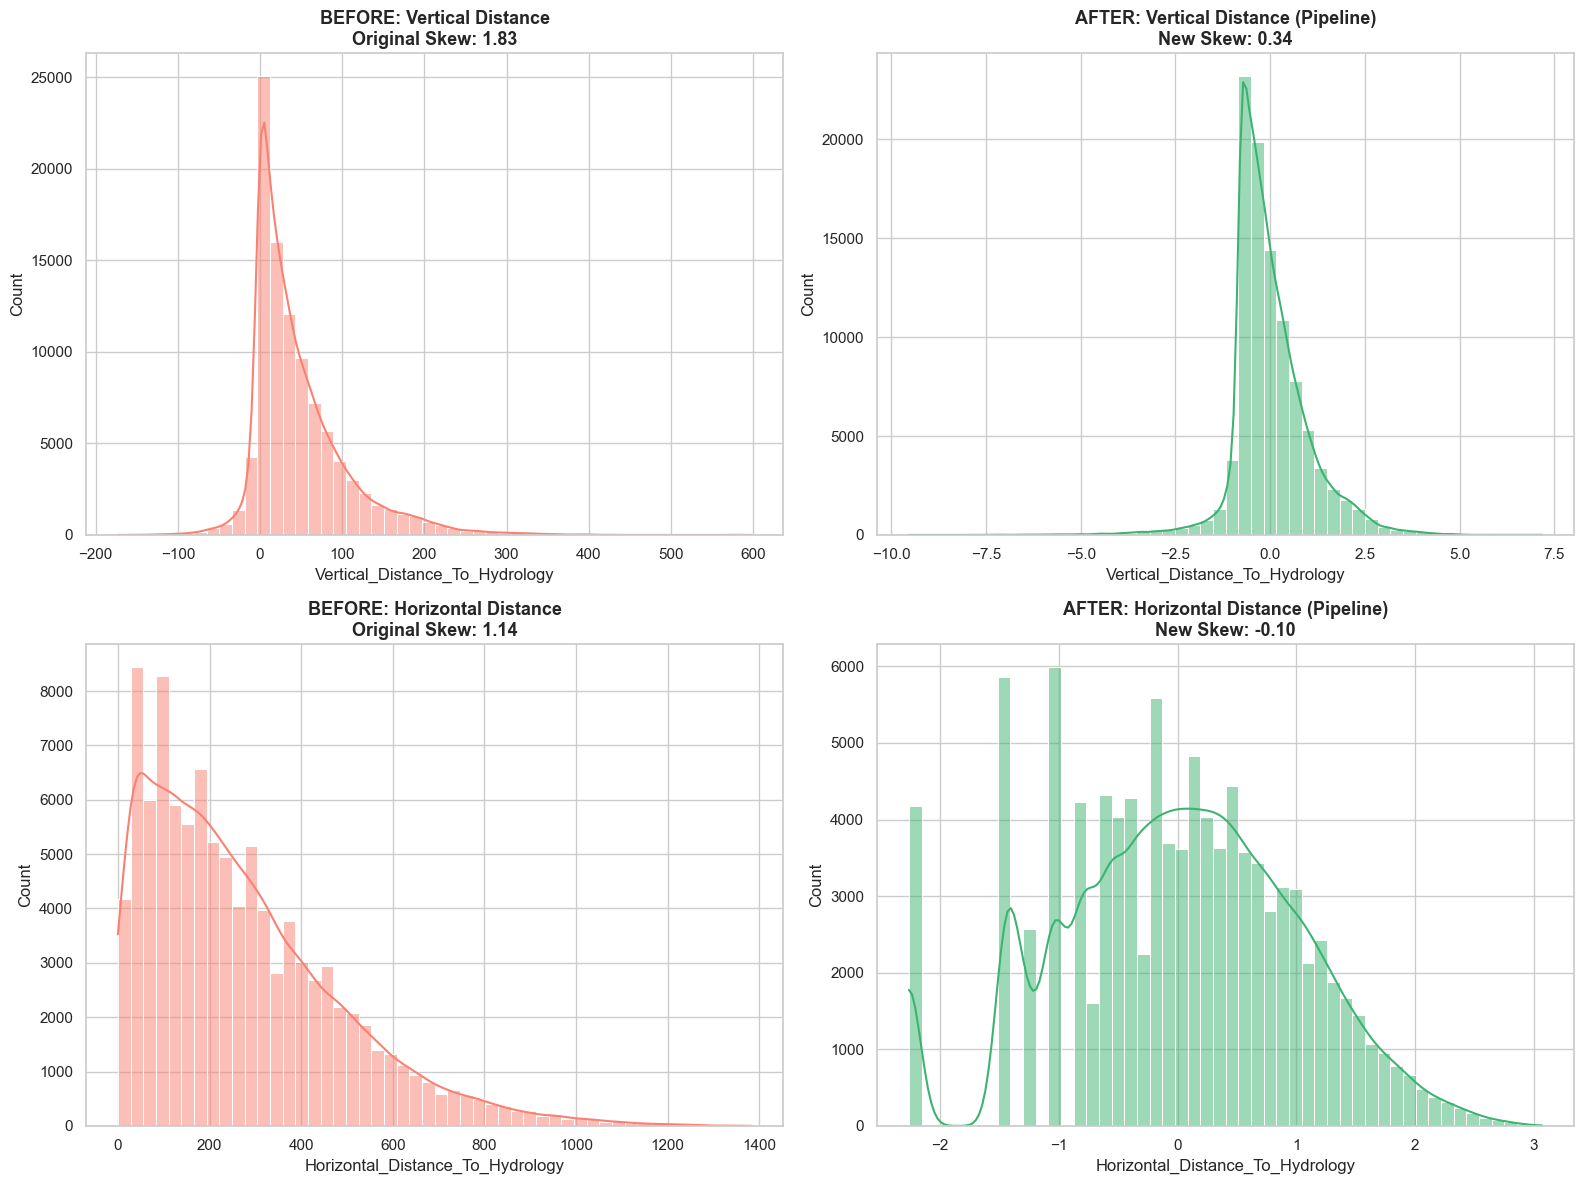

Verification complete.


In [12]:
def visualize_transformations(df):
    print("Initializing Pipeline...")
    # 1. Select the skewed features
    features = ['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology']
    
    # We take a random sample of 100,000 rows just to make the plotting render instantly. 
    # The statistical distribution remains identical to the full 581k dataset.
    df_subset = df[features].sample(n=100000, random_state=42).copy()
    
    # 2. Calculate Original Skewness
    orig_skew_v = skew(df_subset['Vertical_Distance_To_Hydrology'])
    orig_skew_h = skew(df_subset['Horizontal_Distance_To_Hydrology'])
    
    # 3. Build the exact production pipeline
    pipeline = Pipeline(steps=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ])
    
    # 4. Fit and Transform the data
    print("Applying mathematical transformations...")
    transformed_data = pipeline.fit_transform(df_subset)
    df_transformed = pd.DataFrame(transformed_data, columns=features)
    
    # 5. Calculate New Skewness
    trans_skew_v = skew(df_transformed['Vertical_Distance_To_Hydrology'])
    trans_skew_h = skew(df_transformed['Horizontal_Distance_To_Hydrology'])
    
    # 6. Generate the Before & After Plot
    print("Generating visual plots...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Original Vertical
    sns.histplot(df_subset['Vertical_Distance_To_Hydrology'], kde=True, ax=axes[0,0], color='salmon', bins=50)
    axes[0,0].set_title(f"BEFORE: Vertical Distance\nOriginal Skew: {orig_skew_v:.2f}", fontsize=13, fontweight='bold')
    
    # Plot 2: Transformed Vertical
    sns.histplot(df_transformed['Vertical_Distance_To_Hydrology'], kde=True, ax=axes[0,1], color='mediumseagreen', bins=50)
    axes[0,1].set_title(f"AFTER: Vertical Distance (Pipeline)\nNew Skew: {trans_skew_v:.2f}", fontsize=13, fontweight='bold')
    
    # Plot 3: Original Horizontal
    sns.histplot(df_subset['Horizontal_Distance_To_Hydrology'], kde=True, ax=axes[1,0], color='salmon', bins=50)
    axes[1,0].set_title(f"BEFORE: Horizontal Distance\nOriginal Skew: {orig_skew_h:.2f}", fontsize=13, fontweight='bold')
    
    # Plot 4: Transformed Horizontal
    sns.histplot(df_transformed['Horizontal_Distance_To_Hydrology'], kde=True, ax=axes[1,1], color='mediumseagreen', bins=50)
    axes[1,1].set_title(f"AFTER: Horizontal Distance (Pipeline)\nNew Skew: {trans_skew_h:.2f}", fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    print("Verification complete.")

# Assuming your master dataframe is still named 'df'
visualize_transformations(df)

In [ ]:
def train_and_evaluate(df, preprocessor):
    print("Preparing data for modeling...")
    
    # 1. Separate Features (X) and Target (y)
    X = df.drop(columns=['Cover_Type'])
    # The XGBoost Gotcha: Shift classes from 1-7 to 0-6
    y = df['Cover_Type'] - 1 
    
    # 2. Initialize Stratified K-Fold and Model
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # We use tree_method='hist' for massive speedups on large tabular datasets (~581k rows)
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=7,    
        tree_method='hist', 
        random_state=42,
        n_estimators=100, # Baseline: 100 trees
        max_depth=6
    )
    
    mcc_scores = []
    macro_f1_scores = []
    
    print("Starting Stratified 5-Fold Cross Validation...\n" + "-"*50)
    
    # 3. The Validation Loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Training Fold {fold}/5...")
        
        # Split the raw data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # PREVENT DATA LEAKAGE: 
        # Fit the preprocessor ONLY on the training data, then transform both
        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)
        
        # Handle Imbalance: Calculate dynamic sample weights for this specific fold
        # This forces XGBoost to pay massive attention to our rare classes
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        
        # Train the model
        xgb_model.fit(
            X_train_processed, 
            y_train,
            sample_weight=sample_weights,
            eval_set=[(X_val_processed, y_val)],
            verbose=False # Turn off raw XGBoost logs to keep output clean
        )
        
        # Predict on the strictly unseen validation data
        y_pred = xgb_model.predict(X_val_processed)
        
        # Calculate our chosen strict metrics
        fold_mcc = matthews_corrcoef(y_val, y_pred)
        fold_f1 = f1_score(y_val, y_pred, average='macro')
        
        mcc_scores.append(fold_mcc)
        macro_f1_scores.append(fold_f1)
        
        print(f"Fold {fold} Results -> MCC: {fold_mcc:.4f} | Macro F1: {fold_f1:.4f}")
        
    print("-" * 50)
    print(f"BASELINE MODEL PERFORMANCE:")
    print(f"Mean MCC:       {np.mean(mcc_scores):.4f} (+/- {np.std(mcc_scores):.4f})")
    print(f"Mean Macro F1:  {np.mean(macro_f1_scores):.4f} (+/- {np.std(macro_f1_scores):.4f})")
    
    # Generate a final classification report on the last fold to see per-class performance
    print("\nClassification Report (Last Fold):")
    # Adding 1 back to the names so it matches your original dataset documentation
    target_names = [f"Class {i+1}" for i in range(7)] 
    print(classification_report(y_val, y_pred, target_names=target_names))
    
    return xgb_model

# Run the training loop!
trained_model = train_and_evaluate(df, preprocessor)

Preparing data for modeling...
Starting Stratified 5-Fold Cross Validation...
--------------------------------------------------
Training Fold 1/5...
Fold 1 Results -> MCC: 0.7623 | Macro F1: 0.8208
Training Fold 2/5...
Fold 2 Results -> MCC: 0.7703 | Macro F1: 0.8262
Training Fold 3/5...
Fold 3 Results -> MCC: 0.7727 | Macro F1: 0.8226
Training Fold 4/5...
Fold 4 Results -> MCC: 0.7682 | Macro F1: 0.8222
Training Fold 5/5...
Fold 5 Results -> MCC: 0.7689 | Macro F1: 0.8229
--------------------------------------------------
BASELINE MODEL PERFORMANCE:
Mean MCC:       0.7685 (+/- 0.0035)
Mean Macro F1:  0.8229 (+/- 0.0018)

Classification Report (Last Fold):
              precision    recall  f1-score   support

     Class 1       0.84      0.86      0.85     42368
     Class 2       0.91      0.81      0.86     56660
     Class 3       0.88      0.92      0.90      7151
     Class 4       0.82      0.95      0.88       549
     Class 5       0.39      0.98      0.55      1898
     Clas

Generating predictions from trained model...


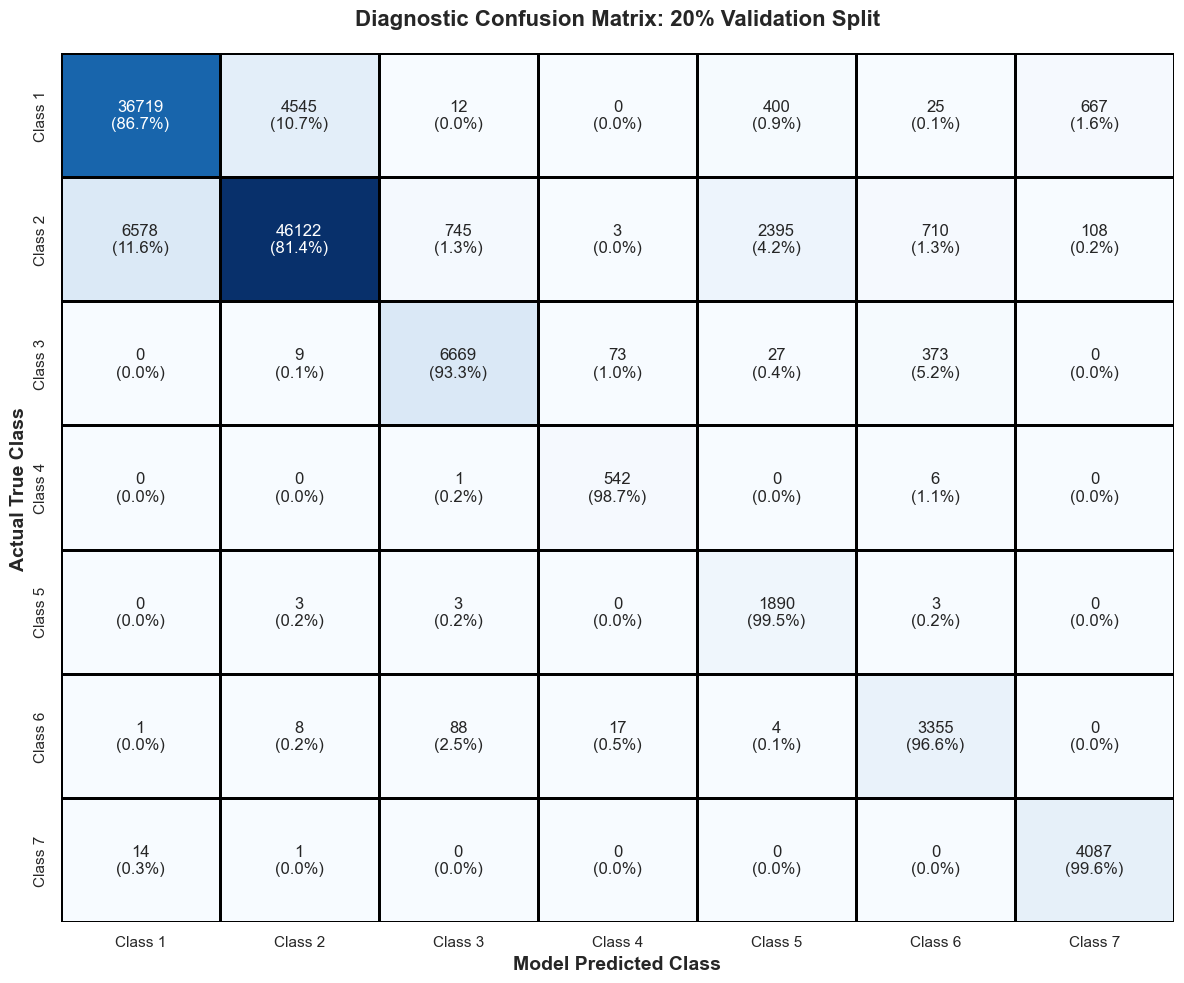

In [14]:
def plot_production_confusion_matrix(y_true, y_pred, classes):
    
    cm = confusion_matrix(y_true, y_pred)
    cm_percentages = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    
    annot_data = (np.asarray(["{0}\n({1:.1%})".format(count, pct) 
                              for count, pct in zip(cm.flatten(), cm_percentages.flatten())])).reshape(cm.shape)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=annot_data, fmt='', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar=False, linewidths=1, linecolor='black')
    
    plt.title('Diagnostic Confusion Matrix: 20% Validation Split', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Actual True Class', fontsize=14, fontweight='bold')
    plt.xlabel('Model Predicted Class', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type'] - 1 
_, X_val_diag, _, y_val_diag = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Process the raw validation data through our established pipeline
X_val_diag_processed = preprocessor.transform(X_val_diag)

# 3. Ask our saved model to make predictions
print("Generating predictions from trained model...")
y_pred_diag = trained_model.predict(X_val_diag_processed)

# 4. Generate the plot
target_names = [f"Class {i+1}" for i in range(7)]
plot_production_confusion_matrix(y_val_diag, y_pred_diag, target_names)


In [15]:
def objective(trial):
    # 1. Define the hyperparameter search space
    param = {
        'objective': 'multi:softmax',
        'num_class': 7,
        'tree_method': 'hist',
        'random_state': 42,
        
        # Bayesian Search Space
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }

    # We will use a smaller 3-Fold CV for speed during tuning
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    mcc_scores = []

    # 2. The Evaluation Loop
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Preprocess
        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)
        
        # We keep the balanced weights, but the new min_child_weight and gamma 
        # parameters will act as a "leash" to stop the False Positives.
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        
        # Train
        model = xgb.XGBClassifier(**param)
        model.fit(X_train_processed, y_train, sample_weight=sample_weights, verbose=False)
        
        # Predict & Evaluate using MCC
        preds = model.predict(X_val_processed)
        mcc = matthews_corrcoef(y_val, preds)
        mcc_scores.append(mcc)
        
    return np.mean(mcc_scores)

# 3. Execute the Optuna Study
print("Initializing Optuna Bayesian Optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("\n" + "="*50)
print("OPTUNA TUNING COMPLETE")
print(f"Best MCC Score: {study.best_value:.4f}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-21 22:33:58,901] A new study created in memory with name: no-name-0a338484-403b-464a-a8f6-54c203d16f31


Initializing Optuna Bayesian Optimization...


[I 2026-02-21 22:36:05,622] Trial 0 finished with value: 0.6408346139658455 and parameters: {'max_depth': 6, 'learning_rate': 0.03970738690403603, 'n_estimators': 293, 'min_child_weight': 5, 'gamma': 3.228620746143178e-07, 'subsample': 0.7592620882914747, 'colsample_bytree': 0.8772176255483526}. Best is trial 0 with value: 0.6408346139658455.
[I 2026-02-21 22:37:51,021] Trial 1 finished with value: 0.8543946835350712 and parameters: {'max_depth': 13, 'learning_rate': 0.04844916541207457, 'n_estimators': 155, 'min_child_weight': 4, 'gamma': 0.035895633860947906, 'subsample': 0.8318351032660998, 'colsample_bytree': 0.7995116283377998}. Best is trial 1 with value: 0.8543946835350712.
[I 2026-02-21 22:39:36,051] Trial 2 finished with value: 0.8274386936237833 and parameters: {'max_depth': 13, 'learning_rate': 0.03156570271322445, 'n_estimators': 153, 'min_child_weight': 3, 'gamma': 1.7553624331952622e-05, 'subsample': 0.6504680813601238, 'colsample_bytree': 0.7099035878829711}. Best is tri


OPTUNA TUNING COMPLETE
Best MCC Score: 0.9469
Best Hyperparameters:
  max_depth: 14
  learning_rate: 0.12271547701800753
  n_estimators: 202
  min_child_weight: 1
  gamma: 0.0017642338458435524
  subsample: 0.9914610277427248
  colsample_bytree: 0.6026607434046372


In [18]:
xgb_best_params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'tree_method': 'hist',
    'device': 'cuda', # Utilizing your GPU
    'random_state': 42,
    'max_depth': 14,
    'learning_rate': 0.12271547701800753,
    'n_estimators': 202,
    'min_child_weight': 1,
    'gamma': 0.0017642338458435524,
    'subsample': 0.9914610277427248,
    'colsample_bytree': 0.6026607434046372
}

def run_production_bakeoff(df, preprocessor):
    
    # Split the Data (80/20 Stratified)
    X = df.drop(columns=['Cover_Type'])
    y = df['Cover_Type'] - 1 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply our master preprocessing pipeline
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Calculate sample weights exclusively for XGBoost
    xgb_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # 2. Initialize the Contenders
    xgb_model = xgb.XGBClassifier(**xgb_best_params)
    
    lgbm_model = lgb.LGBMClassifier(
        class_weight='balanced', # LightGBM handles imbalance natively via this flag
        random_state=42,
        n_estimators=200,
        n_jobs=-1
    )
    
    cat_model = cb.CatBoostClassifier(
        auto_class_weights='Balanced', # CatBoost native imbalance handling
        random_state=42,
        iterations=200,
        verbose=False,
        task_type='GPU', # Leveling the playing field!
        thread_count=-1
    )
    
    models = {
        'Tuned XGBoost': (xgb_model, True), 
        'LightGBM (Baseline)': (lgbm_model, False), 
        'CatBoost (Baseline)': (cat_model, False)
    }
    
    results = []

    # 3. Execute the Race
    print("\n" + "="*50)
    print("STARTING BENCHMARKING RACE")
    print("="*50)
    
    for name, (model, needs_weights) in models.items():
        print(f"Training {name}...")
        
        # Track Training Time
        start_train = time.time()
        if needs_weights:
            model.fit(X_train_processed, y_train, sample_weight=xgb_weights)
        else:
            model.fit(X_train_processed, y_train)
        train_time = time.time() - start_train
        
        # Track Inference Time
        start_infer = time.time()
        preds = model.predict(X_test_processed)
        infer_time = time.time() - start_infer
        
        # Handle CatBoost's 2D array output format
        if len(preds.shape) > 1:
            preds = preds.flatten()
            
        # Record Metrics
        mcc = matthews_corrcoef(y_test, preds)
        macro_f1 = f1_score(y_test, preds, average='macro')
        
        results.append({
            'Model': name,
            'MCC': round(mcc, 4),
            'Macro F1': round(macro_f1, 4),
            'Train Time (s)': round(train_time, 2),
            'Infer Time (s)': round(infer_time, 4)
        })
        
    # 4. Output the Leaderboard
    leaderboard = pd.DataFrame(results).sort_values(by='MCC', ascending=False).reset_index(drop=True)
    print("\nFINAL LEADERBOARD:")
    print(leaderboard.to_string())
    
    return leaderboard, models

# Run the race!
leaderboard, trained_models = run_production_bakeoff(df, preprocessor)


STARTING BENCHMARKING RACE
Training Tuned XGBoost...


d:\Self_Projects\Tensor_flow\env\lib\site-packages\xgboost\core.py:751: UserWarning: [23:19:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Training LightGBM (Baseline)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 464809, number of used features: 56
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


d:\Self_Projects\Tensor_flow\env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training CatBoost (Baseline)...

FINAL LEADERBOARD:
                 Model     MCC  Macro F1  Train Time (s)  Infer Time (s)
0        Tuned XGBoost  0.9474    0.9481           35.92          0.4473
1  LightGBM (Baseline)  0.8043    0.8524            9.18          0.9852
2  CatBoost (Baseline)  0.7481    0.7926            4.03          0.0543


Initializing Final Evaluation Suite...
Generating Predictions and Probabilities...

GENERALIZATION CHECK (Overfitting Test)
Train MCC: 0.9906
Test MCC:  0.9474
Degradation: 0.0431 (Close to 0 is perfectly healthy)

PROBABILITY & RANKING METRICS
Multi-Class ROC-AUC: 0.9989 (Closer to 1.0 is better)
Log Loss: 0.0993 (Lower is better, indicates high confidence in correct answers)

FINAL CLASSIFICATION REPORT (Granular Class Health)
              precision    recall  f1-score   support

     Class 1       0.97      0.97      0.97     42368
     Class 2       0.98      0.97      0.97     56661
     Class 3       0.96      0.97      0.97      7151
     Class 4       0.90      0.92      0.91       549
     Class 5       0.85      0.97      0.90      1899
     Class 6       0.94      0.96      0.95      3473
     Class 7       0.95      0.98      0.97      4102

    accuracy                           0.97    116203
   macro avg       0.94      0.96      0.95    116203
weighted avg       0.97  

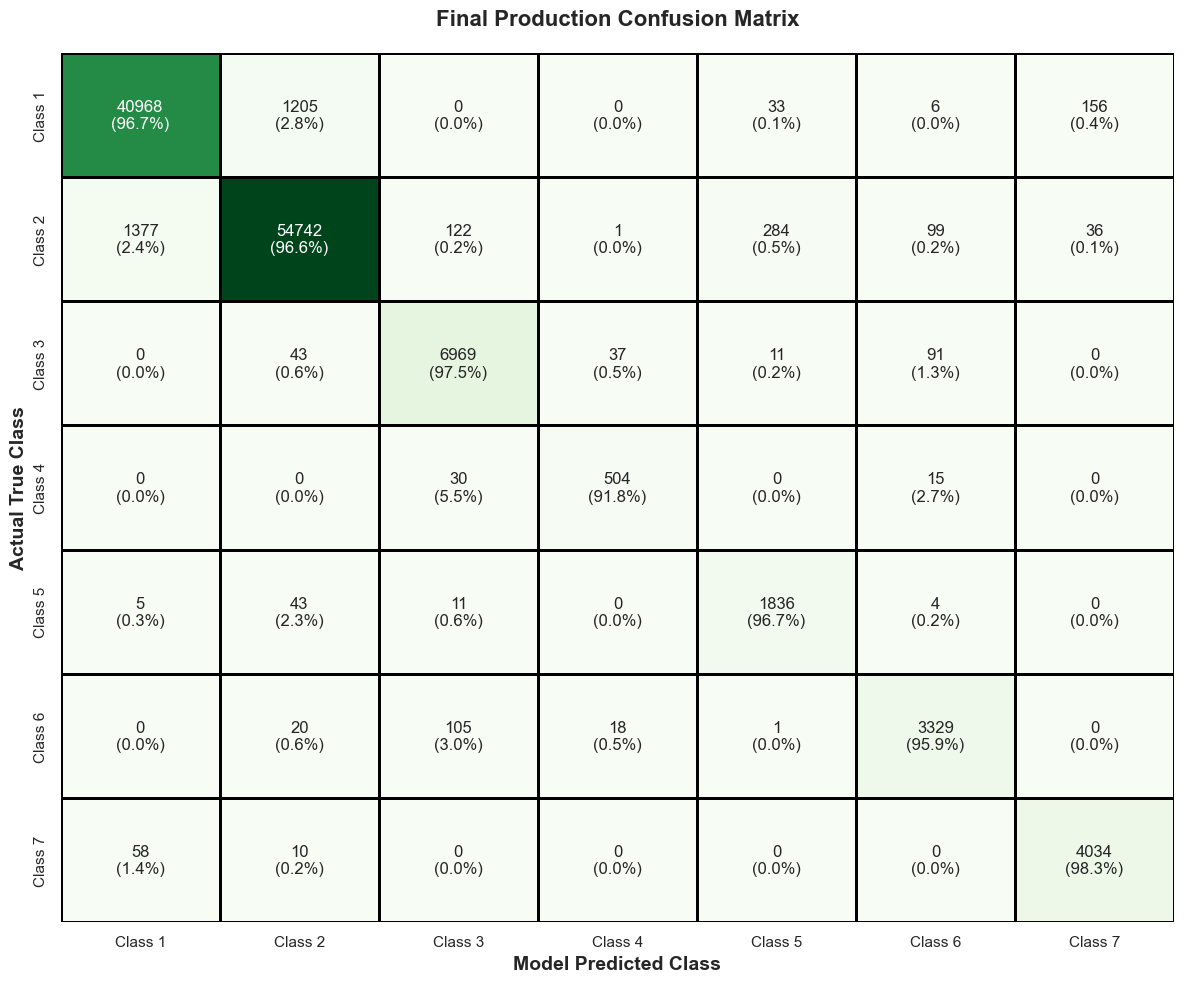

In [20]:
def evaluate_production_model(df, preprocessor, xgb_best_params):
    print("Initializing Final Evaluation Suite...")
    
    # 1. Prepare Data
    X = df.drop(columns=['Cover_Type'])
    y = df['Cover_Type'] - 1 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # 2. Train the Final "Gold" Model
    model = xgb.XGBClassifier(**xgb_best_params)
    model.fit(X_train_processed, y_train, sample_weight=sample_weights)
    
    # 3. Generate Hard Predictions and Probabilities
    print("Generating Predictions and Probabilities...")
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    y_train_proba = model.predict_proba(X_train_processed)
    y_test_proba = model.predict_proba(X_test_processed)

    # 4. Calculate Advanced Metrics
    print("\n" + "="*50)
    print("GENERALIZATION CHECK (Overfitting Test)")
    print("="*50)
    train_mcc = matthews_corrcoef(y_train, y_train_pred)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f"Train MCC: {train_mcc:.4f}")
    print(f"Test MCC:  {test_mcc:.4f}")
    print(f"Degradation: {(train_mcc - test_mcc):.4f} (Close to 0 is perfectly healthy)")

    print("\n" + "="*50)
    print("PROBABILITY & RANKING METRICS")
    print("="*50)
    # ROC-AUC (One-vs-Rest for multi-class)
    roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    print(f"Multi-Class ROC-AUC: {roc_auc:.4f} (Closer to 1.0 is better)")
    
    # Log Loss
    ll = log_loss(y_test, y_test_proba)
    print(f"Log Loss: {ll:.4f} (Lower is better, indicates high confidence in correct answers)")

    print("\n" + "="*50)
    print("FINAL CLASSIFICATION REPORT (Granular Class Health)")
    print("="*50)
    target_names = [f"Class {i+1}" for i in range(7)]
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    # 5. Visual Proof: The Final Confusion Matrix
    print("Rendering Final Confusion Matrix...")
    cm = confusion_matrix(y_test, y_test_pred)
    cm_percentages = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    annot_data = (np.asarray(["{0}\n({1:.1%})".format(count, pct) 
                              for count, pct in zip(cm.flatten(), cm_percentages.flatten())])).reshape(cm.shape)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=annot_data, fmt='', cmap='Greens', 
                xticklabels=target_names, yticklabels=target_names,
                cbar=False, linewidths=1, linecolor='black')
    plt.title('Final Production Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Actual True Class', fontsize=14, fontweight='bold')
    plt.xlabel('Model Predicted Class', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return model

# Run the evaluation!
final_model = evaluate_production_model(df, preprocessor, xgb_best_params)

Extracting Feature Logic from XGBoost...


C:\Users\nafay\AppData\Local\Temp\ipykernel_10848\2010945502.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


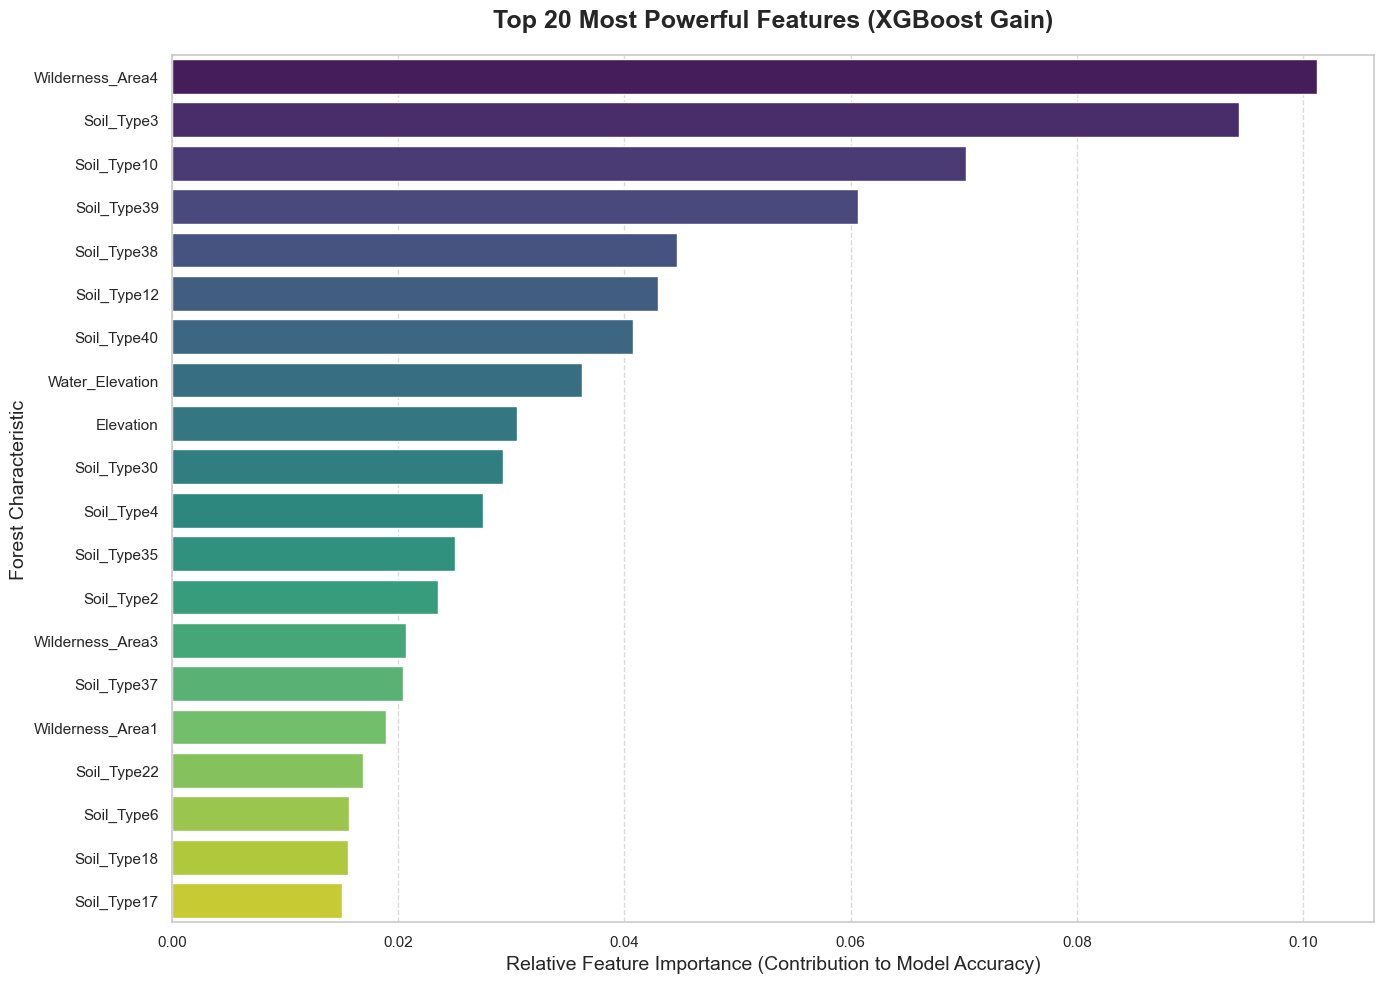


Top 10 Features by Exact Weight:
         Feature  Importance
Wilderness_Area4    0.101178
      Soil_Type3    0.094318
     Soil_Type10    0.070177
     Soil_Type39    0.060644
     Soil_Type38    0.044684
     Soil_Type12    0.042963
     Soil_Type40    0.040724
 Water_Elevation    0.036222
       Elevation    0.030535
     Soil_Type30    0.029249
      Soil_Type4    0.027469
     Soil_Type35    0.025046
      Soil_Type2    0.023479
Wilderness_Area3    0.020685
     Soil_Type37    0.020463
Wilderness_Area1    0.018891
     Soil_Type22    0.016932
      Soil_Type6    0.015613
     Soil_Type18    0.015575
     Soil_Type17    0.014998


In [23]:
def plot_feature_importance(model, continuous_cols, binary_cols):
    print("Extracting Feature Logic from XGBoost...")
    
    # Combine the lists to match the exact order of the pipeline
    all_feature_names = continuous_cols + binary_cols
    
    # Extract the internal "Gain" scores
    importances = model.feature_importances_
    
    # Map the English names back to the math
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })
    
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Plot the Top 20
    plt.figure(figsize=(14, 10))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=importance_df.head(20), 
        palette='viridis'
    )
    
    plt.title('Top 20 Most Powerful Features (XGBoost Gain)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Relative Feature Importance (Contribution to Model Accuracy)', fontsize=14)
    plt.ylabel('Forest Characteristic', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# 1. Explicitly redefine the feature lists so Python knows exactly what they are
continuous_features = [
    'Elevation', 'Aspect', 'Slope', 
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Euclidean_Distance_To_Hydrology', 'Water_Elevation', 'Distance_To_Amenities'
]

binary_features = [col for col in df.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]

# 2. Run the visualization using our final_model!
feature_insights = plot_feature_importance(final_model, continuous_features, binary_features)


print("\nTop 10 Features by Exact Weight:")
print(feature_insights.head(20).to_string(index=False))

In [27]:


def serialize_production_pipeline(model, preprocessor, model_name="xgboost_model.joblib", prep_name="spatial_preprocessor.joblib"):
    print("Initiating Serialization Protocol...")
    
    # 1. Save the trained XGBoost Model
    joblib.dump(model, model_name)
    print(f" Model successfully saved as: {model_name}")
    
    # 2. Save the Scikit-Learn Preprocessor (CRITICAL to prevent Data Leakage in prod)
    joblib.dump(preprocessor, prep_name)
    print(f"Preprocessor successfully saved as: {prep_name}")
    
    # 3. Calculate infrastructure footprint (Memory cost for deployment)
    model_size_mb = os.path.getsize(model_name) / (1024 * 1024)
    prep_size_mb = os.path.getsize(prep_name) / (1024 * 1024)
    
    print("\n" + "="*50)
    print("PIPELINE SERIALIZATION COMPLETE")
    print("="*50)
    print(f"Model Footprint:        {model_size_mb:.2f} MB")
    print(f"Preprocessor Footprint: {prep_size_mb:.2f} MB")
    
    return model_name, prep_name

model_file, preprocessor_file = serialize_production_pipeline(final_model, preprocessor)

Initiating Serialization Protocol...
 Model successfully saved as: xgboost_model.joblib
Preprocessor successfully saved as: spatial_preprocessor.joblib

PIPELINE SERIALIZATION COMPLETE
Model Footprint:        44.87 MB
Preprocessor Footprint: 0.01 MB
